In [28]:
import numpy as np
import cv2
import supervision as sv
from segment_anything import SamPredictor, sam_model_registry
from grounding_dino_demo import detect_with_dino


from const import *
img_path = 'assets/61.jpg'
text_prompt = ", ".join( ['cap', 't shirt', 'sunglasses', 'headband', 'shoe', 'sock', 'backpack', 'walking-sticks', 'bib numbers', 'trousers'])



annotated_frame, boxes,phrases = detect_with_dino(img_path, text_prompt)
cv2.imwrite('assets/61_dino.jpg', annotated_frame)
print (phrases)

final text_encoder_type: bert-base-uncased
['sock' 'shoe' 'bib numbers' 'backpack' 'cap' 'walking - sticks' 'sock'
 'trousers' 'trousers' 't shirt' 'sunglasses']


In [31]:
from GroundingDINO.groundingdino.util import box_ops
from PIL import Image
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(DEVICE), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()
  

def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")


    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [34]:
import numpy as np
from PIL import Image
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_WEIGHTS_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)
image = cv2.imread(img_path)

# Assurez-vous que les bibliothèques et les fonctions requises sont importées et définies avant d'exécuter ce code.


def draw_masks_without_boxes(image, sam_model, boxes):
    masks = segment(image, sam_model, boxes)
    masks_without_boxes = np.zeros_like(image)  # Créer une image vide pour dessiner les masques sans les boîtes
    
    for mask in masks:
        masks_without_boxes = draw_mask(mask, masks_without_boxes, random_color=True)  # Dessiner chaque masque
    
    return masks_without_boxes

# Utilisation :
# Remplacez les valeurs suivantes par vos propres valeurs


# sam_model = Votre modèle
# boxes = Vos boîtes

# Appel de la fonction pour dessiner les masques sans les boîtes
result_image = draw_masks_without_boxes(image, sam_predictor, boxes)

# Afficher l'image résultante
cv2.imwrite('assets/61_sam.jpg', result_image)


True

In [39]:
import numpy as np
import torch
from PIL import Image

# Redéfinition de la fonction draw_mask pour dessiner les masques directement sur l'image originale
def draw_mask_on_image(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    mask = mask.detach().cpu().numpy()  # Convertir le tenseur en tableau NumPy
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")
    image_pil = Image.fromarray(image).convert("RGBA")

    # Superposer le masque sur l'image originale
    final_image = Image.alpha_composite(image_pil, mask_image_pil)

    return np.array(final_image)

def draw_masks_on_original_image(image, sam_model, boxes):
    masks = segment(image, sam_model, boxes)
    masks_list = []  # Liste pour stocker les masques générés
    
    for mask in masks:
        image = draw_mask_on_image(mask, image, random_color=True)  # Dessiner chaque masque sur l'image originale
        masks_list.append(mask.cpu().numpy())
    return image, masks_list

# Utilisation :
# Remplacez les valeurs suivantes par vos propres valeurs
# image = Votre image
# sam_model = Votre modèle
# boxes = Vos boîtes




# Appel de la fonction pour dessiner les masques sur l'image originale
result_image_with_masks, masks = draw_masks_on_original_image(image, sam_predictor, boxes)





# Afficher l'image résultante
cv2.imwrite('assets/61_sam_on_image.jpg', result_image_with_masks)


True

In [46]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
annotated_image = mask_annotator.annotate(scene=image.copy(),)
#annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(annotated_image, (16, 16))

TypeError: MaskAnnotator.annotate() missing 1 required positional argument: 'detections'

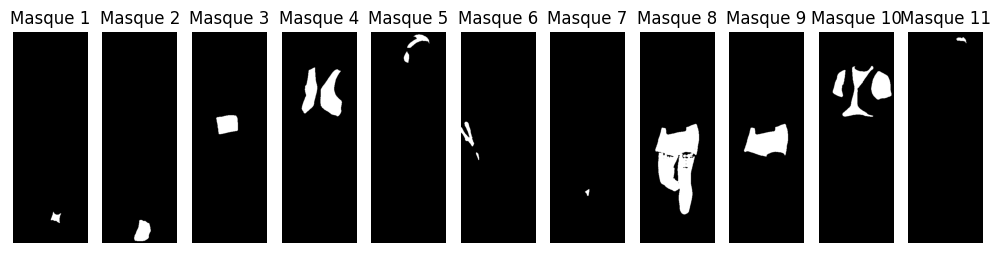

In [42]:
import matplotlib.pyplot as plt

def display_masks(masks_list):
    num_masks = len(masks_list)

    plt.figure(figsize=(10, 6))
    for i in range(num_masks):
        mask = masks_list[i][0] if len(masks_list[i].shape) == 3 else masks_list[i]  # Vérifier la forme du masque
        plt.subplot(1, num_masks, i + 1)
        plt.imshow(mask, cmap='gray')  # Afficher en niveaux de gris si le masque est 2D
        plt.title(f"Masque {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Utilisation :
# Remplacez masks_retrieved par votre liste de masques récupérés


display_masks(masks)


In [37]:
mask = result_image_with_masks.cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [10]:
from groundingdino.util.inference import load_model, load_image, predict, annotate, Model
import cv2
import matplotlib.pyplot as plt
import numpy as np
from const import *
import supervision as sv
img_path = 'assets/61.jpg'
text_prompt = ['cap', 'shirt', 'sunglasses', 'shoe', 'sock', 'backpack', 'sticks', 'bib', 'trousers']






def detect_with_classes (image_path, text_prompt, box_threshold=0.3, text_threshold=0.3):
    image = cv2.imread(image_path)
    grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_T_CHECKPOINT_PATH, device=DEVICE)

    detections, phrases = grounding_dino_model.predict_with_caption(
        image=image,
        caption=", ".join(text_prompt),
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    print (phrases)
    classe_id_list_str =  grounding_dino_model.phrases2classes(phrases, text_prompt)
    detections.class_id = classe_id_list_str
    #detections = detections[detections.class_id != text_prompt.index("trousers")]
    box_annotator = sv.BoxAnnotator()
    annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, labels=phrases)

    return annotated_image, detections, phrases

annotated_frame, detections, phrases = detect_with_classes(img_path, text_prompt)
print (detections)

cv2.imwrite('assets/61_dino_classes.jpg', annotated_frame)

final text_encoder_type: bert-base-uncased


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


['sock', 'shoe', 'trousers', 'backpack', 'sock', 'bib', 'cap', 'sticks', 'shirt']
Detections(xyxy=array([[1.21073555e+02, 5.75049988e+02, 1.55619461e+02, 6.13309021e+02],
       [1.01492485e+02, 6.01684814e+02, 1.55432037e+02, 6.75796387e+02],
       [4.56503067e+01, 2.92485748e+02, 1.91113129e+02, 4.04959015e+02],
       [6.10114365e+01, 1.12602921e+02, 1.93143494e+02, 2.76682373e+02],
       [1.11197922e+02, 5.02639191e+02, 1.27939804e+02, 5.29802795e+02],
       [7.31155930e+01, 2.66925232e+02, 1.49555725e+02, 3.31810242e+02],
       [1.03221039e+02, 1.05842133e+01, 1.87306946e+02, 1.03358253e+02],
       [8.99486542e-02, 2.88401764e+02, 5.96906815e+01, 4.16688263e+02],
       [4.20449829e+01, 1.09656662e+02, 2.34784882e+02, 2.75039856e+02]],
      dtype=float32), mask=None, confidence=array([0.44777787, 0.45318988, 0.4649902 , 0.47461632, 0.32294473,
       0.3166814 , 0.36500782, 0.3490375 , 0.34024072], dtype=float32), class_id=array([4, 3, 8, 5, 4, 7, 0, 6, 1]), tracker_id=None)

True

In [2]:

import numpy as np
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_WEIGHTS_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

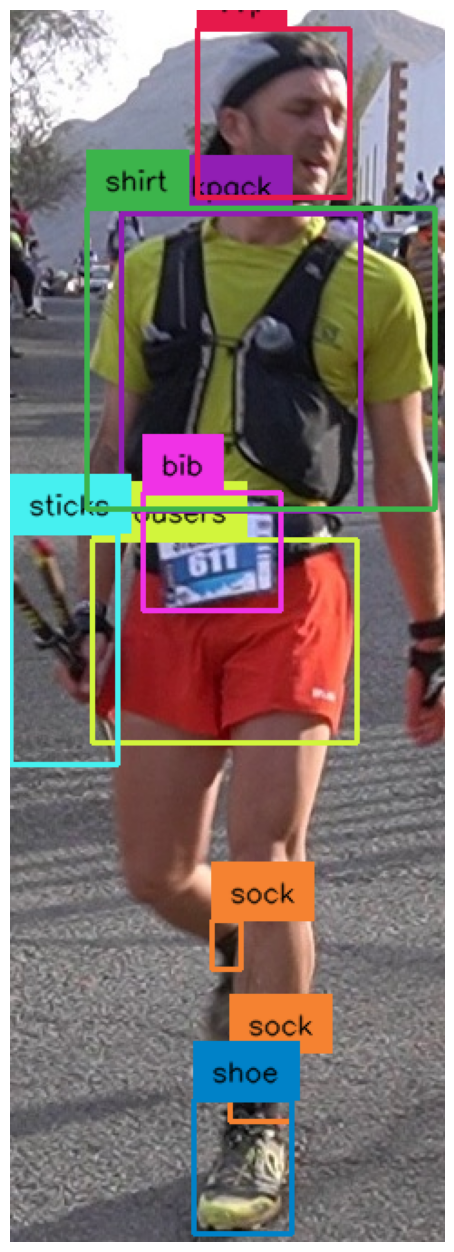

In [7]:
# convert detections to masks
image = cv2.imread(img_path)
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
#annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, labels=phrases)

sv.plot_image(annotated_image, (16, 16))

final text_encoder_type: bert-base-uncased


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


['sock', 'shoe', 'trousers', 'backpack', 'sock', 'bib', 'cap', 'sticks', 'shirt']
Detections(xyxy=array([[1.21073555e+02, 5.75049988e+02, 1.55619461e+02, 6.13309021e+02],
       [1.01492485e+02, 6.01684814e+02, 1.55432037e+02, 6.75796387e+02],
       [4.56503067e+01, 2.92485748e+02, 1.91113129e+02, 4.04959015e+02],
       [6.10114365e+01, 1.12602921e+02, 1.93143494e+02, 2.76682373e+02],
       [1.11197922e+02, 5.02639191e+02, 1.27939804e+02, 5.29802795e+02],
       [7.31155930e+01, 2.66925232e+02, 1.49555725e+02, 3.31810242e+02],
       [1.03221039e+02, 1.05842133e+01, 1.87306946e+02, 1.03358253e+02],
       [8.99486542e-02, 2.88401764e+02, 5.96906815e+01, 4.16688263e+02],
       [4.20449829e+01, 1.09656662e+02, 2.34784882e+02, 2.75039856e+02]],
      dtype=float32), mask=None, confidence=array([0.44777787, 0.45318988, 0.4649902 , 0.47461632, 0.32294473,
       0.3166814 , 0.36500782, 0.3490375 , 0.34024072], dtype=float32), class_id=array([4, 3, 8, 5, 4, 7, 0, 6, 1]), tracker_id=None)

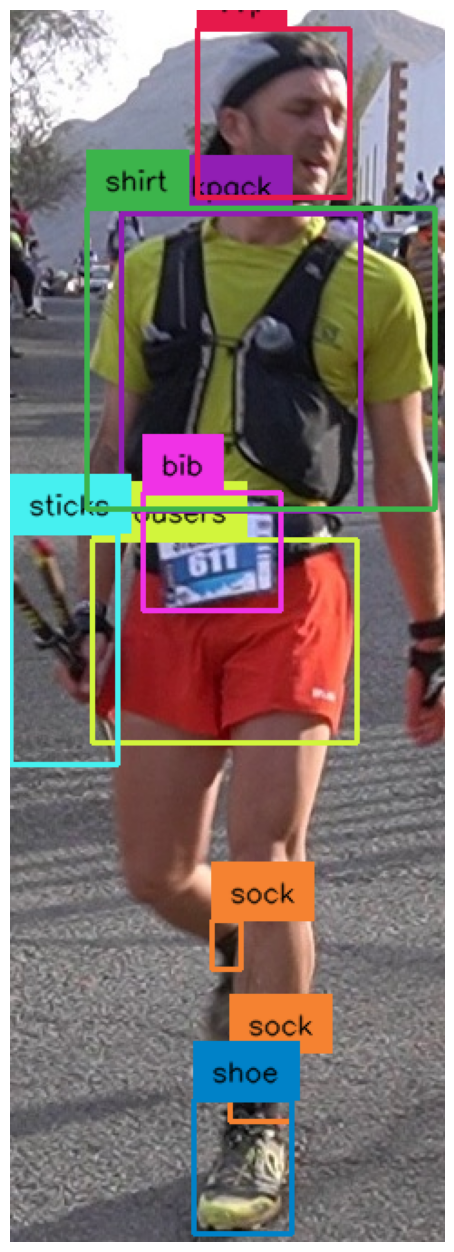

True

In [12]:
from groundingdino.util.inference import load_model, load_image, predict, annotate, Model
import cv2
import matplotlib.pyplot as plt
import numpy as np
from const import *
import supervision as sv
img_path = 'assets/61.jpg'
text_prompt = ['cap', 'shirt', 'sunglasses', 'shoe', 'sock', 'backpack', 'sticks', 'bib', 'trousers']

from dino_detection import detect_with_dino

annotated_frame, detections, phrases = detect_with_dino(img_path, text_prompt)
print (detections)
sv.plot_image( annotated_image, (16, 16))
cv2.imwrite('assets/61_testdino.jpg', annotated_frame)

In [1]:


import torch
import supervision as sv
import os
import cv2
import matplotlib.pyplot as plt

from setup import *
from const import *
from dino_detection import detect_with_dino
from segment import segment
import logging
import numpy as np

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\projetia\analyzer\groundingdino\groundingdino\models\GroundingDINO\ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
print(check_available_weights())
img_path = 'assets/DSC1167.jpg'
text_prompt = ['person']
img = cv2.imread(img_path)
annotated_image, detections, phrases = detect_with_dino(img, text_prompt)

segmented_image, detections2 = segment(detections, img)
# enregistrer les images
cv2.imwrite("assets/segmented_image.jpg", segmented_image)

True


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


True

In [22]:
#print (detections2)
print (detections2.mask[1])
# save the mask 1

cv2.imwrite("assets/mask1.jpg", detections2.mask[1])



True
final text_encoder_type: bert-base-uncased


NameError: name 'image' is not defined

In [ ]:

import math


# plot parameters
grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))


sv.plot_images_grid(
    images = detections.mask,

    grid_size = (grid_size_dimension, grid_size_dimension),
    size = (16, 16)
)

In [ ]:

for i in range(len(detections.mask)):
    # open the original mask
    mask = detections.mask[i]
    

    # manual binarisation
    for j in range(len(mask)):
        for k in range(len(mask[j])):
            if mask[j][k] :
                mask[j][k] = 255
            else:
                mask[j][k] = 0

    # save the new mask
    mask = mask.astype(np.uint8) * 255
    cv2.imwrite(f"assets/tests/mask{i}.jpg", mask)
   



In [3]:
from PIL import Image

In [2]:
def binarize_list_of_masks(list_of_masks):
    binarized_masks = list_of_masks
    for i in range(len(list_of_masks)):
        binarized_masks[i] = binarize_mask(list_of_masks[i])
    return binarized_masks

def binarize_mask(mask):
    binarized_mask= mask
    for j in range(len(mask)):
        for k in range(len(mask[j])):
            if mask[j][k] :
                binarized_mask[j][k] = 255
            else:
                binarized_mask[j][k] = 0
    binarized_mask = binarized_mask.astype(np.uint8) * 255
    return binarized_mask

def plot_masks(list_of_masks):
    
    for i in range(len(list_of_masks)):
        # get mask information
        mask = list_of_masks[i]
        

        # show the mask
        fig, ax = plt.subplots()
        ax.imshow(mask, cmap='gray')
        ax.set_axis_off()
        plt.show()

In [ ]:
plot_masks(binarize_list_of_masks(detections.mask))

In [47]:
print (binarize_mask(detections.mask[0]))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:

def colorize_mask(bin_mask, img):
    
    img_arr = np.asarray(img)
    bin_mask = np.expand_dims(bin_mask, axis=2)
    result_arr = np.bitwise_and(img_arr, bin_mask)
    result_img = Image.fromarray(result_arr)
    #convert to RGB with cv2
    result_img = cv2.cvtColor(np.array(result_img), cv2.COLOR_BGR2RGB)
    return result_img
def colorize_list_of_masks(list_of_masks, img):
    colorized_masks = []
    for i in range(len(list_of_masks)):
        colorized_masks.append(colorize_mask(list_of_masks[i], img))
    return colorized_masks

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


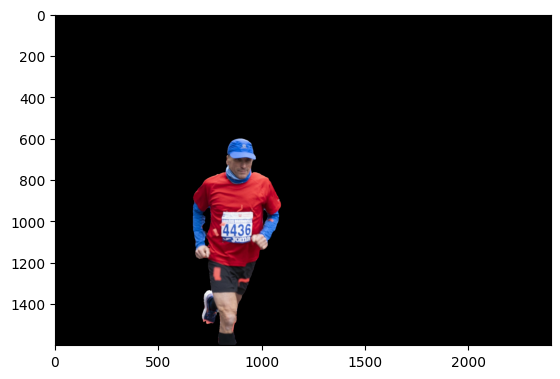

In [67]:
plt.imshow(colorize_mask(binarize_mask(detections.mask[0]), img_path))

In [2]:
from process import * 



c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\projetia\analyzer\groundingdino\groundingdino\models\GroundingDINO\ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
img_path = 'assets/DSC1167.jpg'

img = cv2.imread(img_path)
listA = first_step(img)



c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


In [3]:


second_step(listA, img_path)

In [3]:
img_p =  'assets/tests/p_0_259399375.jpg'
img = cv2.imread(img_p)
text_prompt = ['cap', 'shirt', 'sunglasses', 'shoe', 'sock', 'backpack', 'sticks', 'bib', 'trousers']
annotated_image, segmented_image, detections, phrases = detect_and_segment(img, text_prompt)
print (phrases)

cv2.imwrite('assets/tests/p_0_259399375_dino.jpg', annotated_image)
cv2.imwrite('assets/tests/p_0_259399375_segmented.jpg', segmented_image)


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


['shoe', 'shirt', 'sock', 'cap', 'trousers', 'bib']


True

In [8]:
from color_detection import *

def determine_color(mask_images, label_list, number_of_colors=10):
    tab_average_colors = []
    tab_names = []

    for index, img in enumerate(mask_images):
        color_counts = {}
        bars = []
        hsv_values = []
        tab_names.append(label_list[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        all_counts, centers = calculate_centers(img, number_of_colors)

        counts = []
        for idx, row in enumerate(centers):
            bar, hsv = create_bar(200, 200, row)
            if hsv[2] > 0.03:
                bars.append(bar)
                hsv_values.append(hsv)
                counts.append(all_counts[idx])

        for count, color in zip(counts, hsv_values):
            color_counts[color] = count if color not in color_counts else color_counts[color] + count

        if bars:
            img_bar = np.hstack(bars)

            for idx, row in enumerate(hsv_values):
                image = cv2.putText(img_bar, f'{idx + 1}', (5 + 200 * idx, 200 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

            plt.imshow(image)
            plt.axis('off')
            plt.show()

            for count, color in zip(counts, hsv_values):
                color_counts[color] = count if color not in color_counts else color_counts[color] + count

            tab_colors = []
            tab_nb_pixels = []
            for key, value in color_counts.items():
                tab_colors.append(key)
                tab_nb_pixels.append(value)

            dominant_color = weighted_hsv_mean(tab_colors, tab_nb_pixels)
            tab_average_colors.append(dominant_color)
            print(dominant_color)
            # afficher le label
            print(label_list[index])

    return tab_names, tab_average_colors

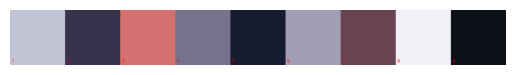

(242, 0.33, 0.41)
shoe


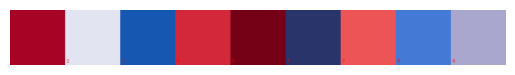

(331, 0.77, 0.71)
shirt


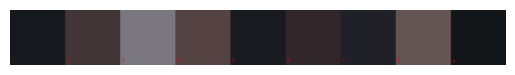

(220, 0.23, 0.13)
sock


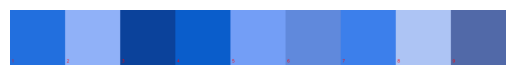

(218, 0.66, 0.88)
cap


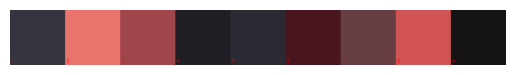

(264, 0.22, 0.27)
trousers


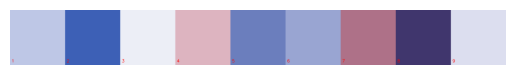

(232, 0.21, 0.87)
bib
shoe :  Dark blue (242, 0.33, 0.41)
shirt :  Pink (331, 0.77, 0.71)
sock :  Black (220, 0.23, 0.13)
cap :  Blue (218, 0.66, 0.88)
trousers :  Grey (264, 0.22, 0.27)
bib :  Dark blue (232, 0.21, 0.87)


In [9]:
tab_names , average_colors_hexa=determine_color(colorize_list_of_masks(binarize_list_of_masks(detections.mask), img), phrases)

#show_colors(average_colors_hexa)

for name , color in zip (tab_names , average_colors_hexa ):
    print(name ,": ", color_or_grayscale(color), color)

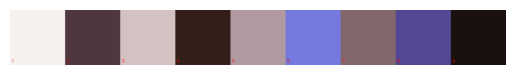

(358, 0.33, 0.41)
shoe


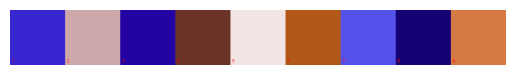

(269, 0.77, 0.71)
shirt


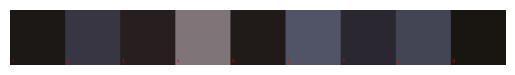

(20, 0.23, 0.13)
sock


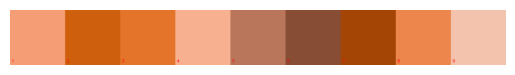

(22, 0.66, 0.88)
cap


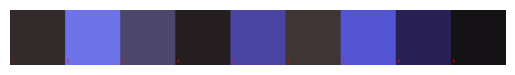

(333, 0.22, 0.26)
trousers


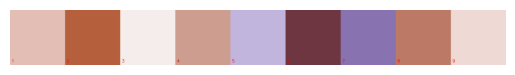

(8, 0.21, 0.87)
bib
(['shoe', 'shirt', 'sock', 'cap', 'trousers', 'bib'], [(358, 0.33, 0.41), (269, 0.77, 0.71), (20, 0.23, 0.13), (22, 0.66, 0.88), (333, 0.22, 0.26), (8, 0.21, 0.87)])


In [10]:
# creer une personne grace au model 
from model import *

new_person =cre


In [4]:
text_prompt = ['person']
annotated_image, segmented_image, detections, phrases = detect_and_segment(img, text_prompt)

binarized_list_of_masks=binarize_list_of_masks(detections.mask)
colorized_list_of_masks=colorize_list_of_masks(binarized_list_of_masks, img)

c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


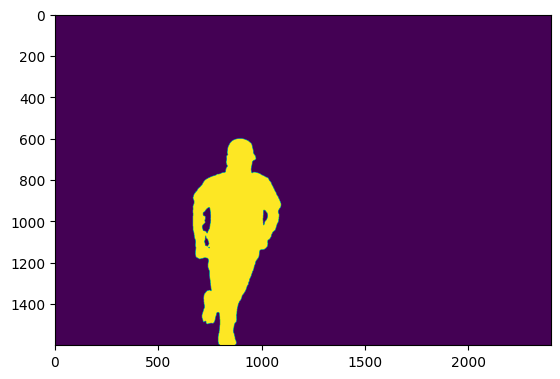

In [5]:
plt.imshow( binarized_list_of_masks[0])
print (binarize_mask(detections.mask[0]))
print (binarized_list_of_masks[0])


In [7]:
second_step(colorized_list_of_masks)